<a href="https://colab.research.google.com/github/zihoo318/TalkLithic-TalkAnalysis-/blob/master/Talk%EC%84%9D%EA%B8%B0_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 필요한 패키지 설치
!apt-get update
!apt-get install -y curl git build-essential
!apt-get install -y openjdk-11-jdk     # Java Development Kit (JDK) 설치

# JPype1 설치
!pip install JPype1

# konlpy 설치
!pip install konlpy

# chardet 라이브러리 설치
!pip install chardet


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [929 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,479 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com

In [ ]:
#personal.txt에 형태소 분석 된 결과 저장하는 코드
#사용안함
import re
from konlpy.tag import Okt
from collections import defaultdict

class User:
    def __init__(self, name):
        self.name = name
        self.typo_count = 0
        self.initial_message_count = 0  # 초성 사용 횟수
        self.message_count = 0  # 메시지 보낸 횟수
        self.emoji_count = 0  # 이모티콘 횟수 등 추가 정보
        self.personal_file_path = f'/content/{self.name}_personal.txt'  # 개인 파일 경로 초기화

class ChatRoom:
    def __init__(self, file_path):
        self.file_path = file_path
        self.room_name = self.extract_room_name()
        self.members = {}  # 사용자 이름을 키로 하고 User 객체를 값으로 하는 딕셔너리
        self.user_chats = defaultdict(str)
        self.total_chats = []
        self.okt = Okt()  # Okt 객체 생성
        self.group_file_path = '/content/group.txt'
        self.excluded_jamo_set = {'ㅋ', 'ㅍ', 'ㅎ', 'ㅌ'}  # 제외할 자음 집합

    def extract_room_name(self):
        with open(self.file_path, 'r', encoding='utf-8') as file:
            first_line = file.readline()
            room_name = first_line.split(" 님과")[0]
            return room_name.strip()

    def preprocess_and_analyze(self):
        # 텍스트 파일 읽기
        with open(self.file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        # 날짜 정보 제거
        text = re.sub(r'저장한 날짜 : \d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', '', text)
        text = re.sub(r'--------------- \d{4}년 \d{1,2}월 \d{1,2}일 \w+ ---------------', '', text)

        # 정규 표현식을 사용하여 사용자별 메시지를 추출
        lines = text.split('\n')
        for line in lines:
            match = re.match(r'\[(.+?)\] \[.+?\] (.+)', line)
            if match:
                user_name = match.group(1).strip()
                message = match.group(2).strip()

                # 사용자 객체 생성 또는 가져오기
                if user_name not in self.members:
                    self.members[user_name] = User(user_name)

                user = self.members[user_name]

                # 형태소 분석 후 처리
                tokens = self.okt.morphs(message)
                for token in tokens:
                    if self.is_jamo_only(token):
                        user.typo_count += 1
                    elif self.is_jamo(token):
                      if not self.is_excluded_jamo(token):
                            user.initial_message_count += 1

                user.message_count += 1  # 메시지 보낸 횟수 증가
                self.user_chats[user_name] += message + ' '
                self.total_chats.append(message)

        # 개인별 형태소 분석 결과 저장
        for user_name, chat in self.user_chats.items():
            morphs = self.okt.morphs(chat)
            user = self.members[user_name]
            with open(user.personal_file_path, 'w', encoding='utf-8') as file:
                file.write(' '.join(morphs))

        # 전체 형태소 분석 결과 저장
        group_results = self.okt.morphs(' '.join(self.total_chats))
        with open(self.group_file_path, 'w', encoding='utf-8') as file:
            file.write(' '.join(group_results))

        # 오타 카운트 결과 출력
        print("오타 카운트:")
        for user_name, user in self.members.items():
            print(f"{user_name}: {user.typo_count}개")

    def is_jamo_only(self, word):
        # 한글 자모음으로만 구성된 단어인지 체크
        jamo_pattern = re.compile("[ㄱ-ㅎㅏ-ㅣ]+")
        return bool(jamo_pattern.fullmatch(word))

    def is_jamo(self, word):
        # 한글 자음으로만 구성된 단어인지 체크
        jamo_pattern = re.compile("[ㄱ-ㅎ]+")
        return bool(jamo_pattern.fullmatch(word))

    def is_excluded_jamo(self, word):
        # 제외할 자음 또는 모음으로만 구성된 단어인지 체크
        return all(char in self.excluded_jamo_set for char in word)

    def get_member_count(self):
        return len(self.members)

    def get_members(self):
        return list(self.members.keys())

    def get_user_info(self, user_name):
        if user_name in self.members:
            user = self.members[user_name]
            return f"이름: {user.name}, 오타 개수: {user.typo_count}, 초성 사용 횟수: {user.initial_message_count}, 메시지 수: {user.message_count}"
        else:
            return f"{user_name} 사용자 정보 없음"

    def get_personal_file_path(self, user_name):
        if user_name in self.members:
            return self.members[user_name].personal_file_path
        else:
            return None

    def get_group_file_path(self):
        return self.group_file_path

# 파일 경로 설정
file_path = '/content/KakaoTalk_20240624_2306_01_181_group.txt'

# ChatRoom 객체 생성 및 분석 수행
chat_room = ChatRoom(file_path)
chat_room.preprocess_and_analyze()

# 채팅방 정보 출력
print(f"채팅방 이름: {chat_room.room_name}")
print(f"채팅방 인원 수: {chat_room.get_member_count()}")
print(f"멤버들: {', '.join(chat_room.get_members())}")

# 개인별 파일 경로 출력
for user_name in chat_room.get_members():
    print(f"{user_name}의 개인 파일 경로: {chat_room.get_personal_file_path(user_name)}")

# 특정 사용자 정보 출력 예시
user_name = '강지후'
print(chat_room.get_user_info(user_name))


오타 카운트:
최서진: 11385개
이연우: 12123개
권구진: 16854개
채수진: 9013개
강지후: 4899개
신유진: 2838개
전화영우: 2개
채팅방 이름: 오굿
채팅방 인원 수: 7
멤버들: 최서진, 이연우, 권구진, 채수진, 강지후, 신유진, 전화영우
최서진의 개인 파일 경로: /content/최서진_personal.txt
이연우의 개인 파일 경로: /content/이연우_personal.txt
권구진의 개인 파일 경로: /content/권구진_personal.txt
채수진의 개인 파일 경로: /content/채수진_personal.txt
강지후의 개인 파일 경로: /content/강지후_personal.txt
신유진의 개인 파일 경로: /content/신유진_personal.txt
전화영우의 개인 파일 경로: /content/전화영우_personal.txt
이름: 강지후, 오타 개수: 4899, 초성 사용 횟수: 0, 메시지 수: 22648


In [4]:
#########사용코드##########
#워드클라우드를 위해 personal.txt, group.txt가 형태소 분석으로 인해 형태가 변하지 않고 오타만 거른 상태로 저장되도록 하기 위한
#언급 카운트 추가

import re
from konlpy.tag import Okt
from collections import defaultdict

class User:
    def __init__(self, name):
        self.name = name
        self.typo_count = 0 #오타 횟수
        self.initial_message_count = 0  # 초성 사용 횟수
        self.message_count = 0  # 메시지 보낸 횟수
        #self.emoji_count = 0  # 이모티콘 횟수
        self.personal_file_path = f'/content/{self.name}_personal.txt'  # 개인 파일 경로 초기화
        #self.mentioned_count=0 #본인이 언급된 경우 카운트
        #self.mentionAnother_count #다른 사람을 언급하는 경우 카운트

class ChatRoom:
    def __init__(self, file_path):
        self.file_path = file_path
        self.room_name = self.extract_room_name()
        self.members = {}  # 사용자 이름을 키로 하고 User 객체를 값으로 하는 딕셔너리
        self.user_chats = defaultdict(str)
        self.total_chats = []
        self.okt = Okt()  # Okt 객체 생성
        self.group_file_path = '/content/group.txt'
        self.excluded_jamo_set = {'ㅋ', 'ㅍ', 'ㅎ', 'ㅌ'}  # 제외할 자음 집합

    def extract_room_name(self):
        with open(self.file_path, 'r', encoding='utf-8') as file:
            first_line = file.readline()
            room_name = first_line.split(" 님과")[0]
            return room_name.strip()

    def preprocess_and_analyze(self):
        # 텍스트 파일 읽기
        with open(self.file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        # 날짜 정보 제거
        text = re.sub(r'저장한 날짜 : \d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', '', text)
        text = re.sub(r'--------------- \d{4}년 \d{1,2}월 \d{1,2}일 \w+ ---------------', '', text)

        # 정규 표현식을 사용하여 사용자별 메시지를 추출
        lines = text.split('\n')
        for line in lines:
            match = re.match(r'\[(.+?)\] \[.+?\] (.+)', line)
            if match:
                user_name = match.group(1).strip() #보낸이
                message = match.group(2).strip() #보낸 메세지

                # 사용자 객체 생성 또는 가져오기
                if user_name not in self.members:
                    self.members[user_name] = User(user_name)

                user = self.members[user_name]

                # 형태소 분석 후 처리
                tokens = self.okt.morphs(message)
                for token in tokens:
                    if self.is_jamo_only(token):
                        user.typo_count += 1
                    elif self.is_jamo(token):
                      if not self.is_excluded_jamo(token):
                            user.initial_message_count += 1

                user.message_count += 1  # 메시지 보낸 횟수 증가
                self.user_chats[user_name] += message + ' '
                self.total_chats.append(message)

                # # 언급 처리
                # mentions = re.findall(r'@(\w+)', message) #한 라인에서 추출된 언급이름 저장하는 리스트 mentions
                # for mentioned_name in mentions:
                #     mentioned_name = mentioned_name.strip() #공백 제거
                #     if mentioned_name in self.members:
                #         self.members[mentioned_name].mentioned_count += 1 #언급된 사람 카운트 증가
                #         user.mentionAnother_count += 1 #언급한 사람 카운드 증가


        # 개인별 메시지 저장 (오타 거른 상태로 저장)
        for user_name, chat in self.user_chats.items():
            user = self.members[user_name]
            with open(user.personal_file_path, 'w', encoding='utf-8') as file:
                # 각 메시지를 공백을 기준으로 나누어 처리
                words = chat.split()
                for word in words:
                    word_without_spaces = word.replace(' ', '')
                    if self.is_jamo_only(word_without_spaces):
                      # 오타가 있는 경우 처리하지 않고 건너뜁니다.
                      continue
                    else:
                      # 파일에 저장
                      file.write(word + ' ')

        # 전체 메시지 저장 (오타 거른 상태로 저장)
        with open(self.group_file_path, 'w', encoding='utf-8') as file:
            for message in self.total_chats:
                words = message.split()
                for word in words:
                    word_without_spaces = word.replace(' ', '')
                    if self.is_jamo_only(word_without_spaces):
                      # 오타가 있는 경우 처리하지 않고 건너뜁니다.
                      continue
                    else:
                      # 파일에 저장
                      file.write(word + ' ')
                file.write('\n')  # 각 메시지를 줄 단위로 구분



        # 오타 카운트 결과 출력
        print("오타 카운트:")
        for user_name, user in self.members.items():
            print(f"{user_name}: {user.typo_count}개")

    def is_jamo_only(self, word):
        # 한글 자모음으로만 구성된 단어인지 체크
        jamo_pattern = re.compile("[ㄱ-ㅎㅏ-ㅣ]+")
        return bool(jamo_pattern.fullmatch(word))

    def is_jamo(self, word):
        # 한글 자음으로만 구성된 단어인지 체크
        jamo_pattern = re.compile("[ㄱ-ㅎ]+")
        return bool(jamo_pattern.fullmatch(word))

    def is_excluded_jamo(self, word):
        # 제외할 자음 또는 모음으로만 구성된 단어인지 체크
        return all(char in self.excluded_jamo_set for char in word)

    def get_member_count(self):
        return len(self.members)

    def get_members(self):
        return list(self.members.keys())

    def get_user_info(self, user_name):
        if user_name in self.members:
            user = self.members[user_name]
            return f"이름: {user.name}, 오타 개수: {user.typo_count}, 초성 사용 횟수: {user.initial_message_count}, 메시지 수: {user.message_count}"
        else:
            return f"{user_name} 사용자 정보 없음"

    def get_personal_file_path(self, user_name):
        if user_name in self.members:
            return self.members[user_name].personal_file_path
        else:
            return None

    def get_group_file_path(self):
        return self.group_file_path

# 파일 경로 설정
file_path = '/content/KakaoTalk.txt'

# ChatRoom 객체 생성 및 분석 수행
chat_room = ChatRoom(file_path)
chat_room.preprocess_and_analyze()

# 채팅방 정보 출력
print(f"채팅방 이름: {chat_room.room_name}")
print(f"채팅방 인원 수: {chat_room.get_member_count()}")
print(f"멤버들: {', '.join(chat_room.get_members())}")

# 개인별 파일 경로 출력
for user_name in chat_room.get_members():
    print(f"{user_name}의 개인 파일 경로: {chat_room.get_personal_file_path(user_name)}")

# 특정 사용자 정보 출력 예시
user_name = '강지후'
print(chat_room.get_user_info(user_name))


오타 카운트:
권현서: 445개
홍서연: 94개
강지후: 298개
이정원: 335개
이윤서: 58개
채팅방 이름: 🌷화환즈🌷
채팅방 인원 수: 5
멤버들: 권현서, 홍서연, 강지후, 이정원, 이윤서
권현서의 개인 파일 경로: /content/권현서_personal.txt
홍서연의 개인 파일 경로: /content/홍서연_personal.txt
강지후의 개인 파일 경로: /content/강지후_personal.txt
이정원의 개인 파일 경로: /content/이정원_personal.txt
이윤서의 개인 파일 경로: /content/이윤서_personal.txt
이름: 강지후, 오타 개수: 298, 초성 사용 횟수: 0, 메시지 수: 1147


In [3]:
# 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq


Selecting previously unselected package fonts-nanum.
(Reading database ... 122422 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


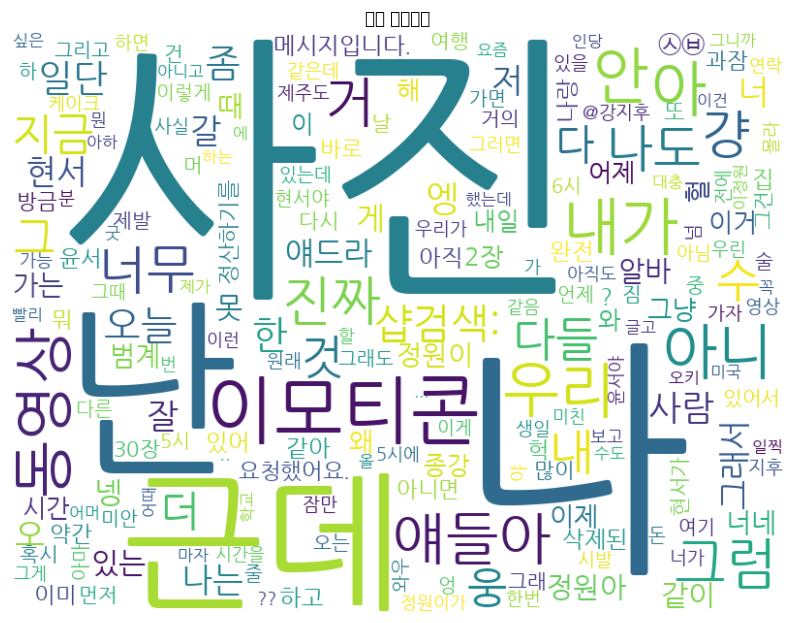

In [15]:
#워드클라우드 생성
#필터링 하지 않고 전처리과정에서 오타만 거른 파일로 그대로 워드클라운드 생성
# 최소 빈도수 이상인 단어들만 필터링 현재 min_frequency=25
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

def generate_wordcloud_from_file(personal_file_path):
    if not os.path.exists(personal_file_path):
        print(f"파일이 존재하지 않습니다: {personal_file_path}")
        return

    # 개인 파일에서 형태소 분석 결과 읽기
    with open(personal_file_path, 'r', encoding='utf-8') as file:
        morphs = file.read().split()

    # 형태소 빈도 계산
    word_counts = Counter(morphs)
    # 최소 빈도수 이상인 단어들만 필터링
    min_frequency=25
    filtered_word_counts = {word: count for word, count in word_counts.items() if count >= min_frequency}

    # 워드 클라우드 생성
    wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                          background_color='white', width=800, height=600).generate_from_frequencies(word_counts)

    # 워드 클라우드 출력
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("워드 클라우드")
    plt.show()

# ChatRoom 클래스의 필요한 부분을 이곳에 가져와서 사용 가능합니다
# 파일 경로 설정
file_path = '/content/KakaoTalk.txt'

# ChatRoom 객체 생성
#chat_room = ChatRoom(file_path)

# ChatRoom 객체를 사용하여 분석 수행
#chat_room.preprocess_and_analyze()

# 워드클라우드 생성 및 출력 예시
user_name = '강지후'
personal_file_path = chat_room.get_personal_file_path(user_name)
generate_wordcloud_from_file(personal_file_path)
#워드클라우드 group 출력
#generate_wordcloud_from_file('/content/group.txt')


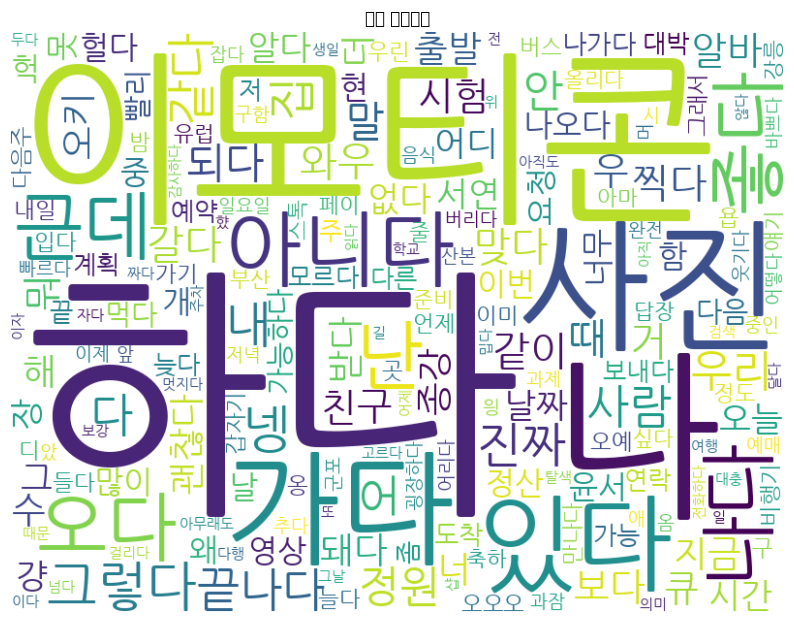

In [6]:
#필터링 후 워드클라우드 생성
#사용 안하기로 결정
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Okt 객체 생성
okt = Okt()

def filter_words_from_file(input_file, output_file):
    if not os.path.exists(input_file):
        print(f"파일이 존재하지 않습니다: {input_file}")
        return

    results = []

    # 파일에서 내용 읽기
    with open(input_file, 'r', encoding='utf-8') as fp:
        lines = fp.readlines()

    # 각 줄에 대해 형태소 분석 및 명사/동사/부사/대명사 필터링
    for line in lines:
        malist = okt.pos(line, norm=True, stem=True)
        filtered_words = []
        for word, pos in malist:
            # 명사, 동사, 부사, 대명사만 필터링
            if pos in ['Noun', 'Verb', 'Adjective', 'Adverb', 'Pronoun']:
                filtered_words.append(word)

        # 현재 줄에서 추출된 단어들을 문자열로 변환하여 결과 리스트에 추가
        rl = " ".join(filtered_words).strip()
        results.append(rl)

    # 결과를 파일로 저장
    with open(output_file, 'w', encoding='utf-8') as fp2:
        fp2.write("\n".join(results))

def generate_wordcloud_from_file(personal_file_path):
    if not os.path.exists(personal_file_path):
        print(f"파일이 존재하지 않습니다: {personal_file_path}")
        return

    # 개인 파일에서 형태소 분석 결과 읽기
    with open(personal_file_path, 'r', encoding='utf-8') as file:
        morphs = file.read().split()

    # 형태소 빈도 계산
    word_counts = Counter(morphs)

    # 워드 클라우드 생성
    wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                          background_color='white', width=800, height=600).generate_from_frequencies(word_counts)

    # 워드 클라우드 출력
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("워드 클라우드")
    plt.show()

# 파일 경로 설정
file_path = '/content/KakaoTalk_20240624_2306_01_181_group.txt'

# ChatRoom 객체 생성
# chat_room = ChatRoom(file_path)

# ChatRoom 객체를 사용하여 분석 수행
# chat_room.preprocess_and_analyze()

# 개인 파일 경로 가져오기 (예시로 강지후 사용)
user_name = '강지후'
personal_file_path = '/content/' + user_name + '_personal.txt'

# 개인 파일에서 명사/동사/부사/대명사 필터링하여 새로운 파일 생성
filtered_file_path = '/content/' + user_name + '_filtered.txt'
filter_words_from_file(personal_file_path, filtered_file_path)

# 필터링된 파일을 사용하여 워드클라우드 생성 및 출력
generate_wordcloud_from_file(filtered_file_path)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


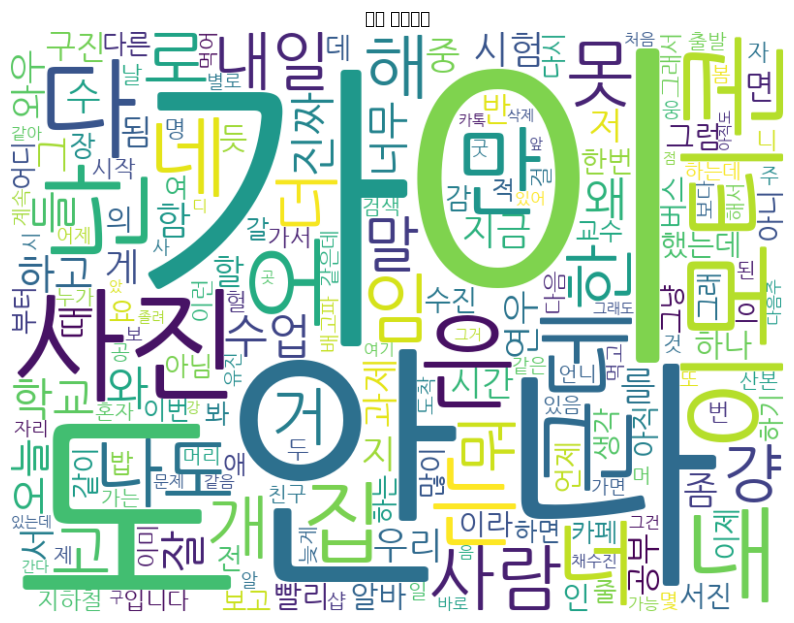

In [ ]:
#원형 변환 안하고 필터링 후 워드클라우드 생성
#사용 안함
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Okt 객체 생성
okt = Okt()

def filter_words_from_file(input_file, output_file):
    if not os.path.exists(input_file):
        print(f"파일이 존재하지 않습니다: {input_file}")
        return

    results = []

    # 파일에서 내용 읽기
    with open(input_file, 'r', encoding='utf-8') as fp:
        lines = fp.readlines()

    # 각 줄에 대해 형태소 분석 및 명사/동사/부사/대명사 필터링
    for line in lines:
        malist = okt.pos(line)
        filtered_words = []
        for word, pos in malist:
            # 명사, 동사, 부사, 대명사만 필터링
            if pos in ['Noun', 'Verb', 'Adjective', 'Adverb', 'Pronoun']:
                filtered_words.append(word)

        # 현재 줄에서 추출된 단어들을 문자열로 변환하여 결과 리스트에 추가
        rl = " ".join(filtered_words).strip()
        results.append(rl)

    # 결과를 파일로 저장
    with open(output_file, 'w', encoding='utf-8') as fp2:
        fp2.write("\n".join(results))

def generate_wordcloud_from_file(personal_file_path):
    if not os.path.exists(personal_file_path):
        print(f"파일이 존재하지 않습니다: {personal_file_path}")
        return

    # 개인 파일에서 형태소 분석 결과 읽기
    with open(personal_file_path, 'r', encoding='utf-8') as file:
        morphs = file.read().split()

    # 형태소 빈도 계산
    word_counts = Counter(morphs)

    # 워드 클라우드 생성
    wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                          background_color='white', width=800, height=600).generate_from_frequencies(word_counts)

    # 워드 클라우드 출력
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("워드 클라우드")
    plt.show()

# 파일 경로 설정
file_path = '/content/KakaoTalk_20240624_2306_01_181_group.txt'

# ChatRoom 객체 생성
# chat_room = ChatRoom(file_path)

# ChatRoom 객체를 사용하여 분석 수행
# chat_room.preprocess_and_analyze()

# 개인 파일 경로 가져오기 (예시로 강지후 사용)
user_name = '강지후'
personal_file_path = '/content/' + user_name + '_personal.txt'

# 개인 파일에서 형태소 분석 없이 필터링하여 새로운 파일 생성
filtered_file_path = '/content/' + user_name + '_filtered.txt'
filter_words_from_file(personal_file_path, filtered_file_path)

# 필터링된 파일을 사용하여 워드클라우드 생성 및 출력
generate_wordcloud_from_file(filtered_file_path)


In [ ]:
#랭킹

밑으로는 해야할 기능

In [ ]:
#발신자 예측
# 예시로 대화를 보낸 사람들을 그룹화하여 워드 임베딩 생성
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 예시로 사용할 데이터
data = {
    'sender': [sender1, sender2],
    'message': messages
}

# 보낸 사람들의 대화를 벡터화
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['message'])

# LDA 모델 학습
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(X)

# 각 문장에 대한 주제 할당
topic_assignments = lda.transform(X)

# 예측 함수 정의
def predict_sender(input_text):
    input_vector = vectorizer.transform([input_text])
    input_topic = lda.transform(input_vector)

    if input_topic[0][0] > input_topic[0][1]:
        return sender1
    else:
        return sender2

# 예측 테스트
input_text = "안녕하세요"
predicted_sender = predict_sender(input_text)
print(f"입력한 문장 '{input_text}'를 가장 자주 사용하는 발신자는 '{predicted_sender}'입니다.")


In [ ]:
#활동시간 분석
import pandas as pd
from datetime import datetime

# 예시 데이터 생성
message_times = [
    "2024-06-01 10:00", "2024-06-01 11:30", "2024-06-01 12:45",
    "2024-06-02 09:00", "2024-06-02 10:30", "2024-06-02 12:00",
    "2024-06-03 14:00", "2024-06-03 15:30", "2024-06-03 17:00"
]

# 날짜와 시간별 메시지 수 계산
message_counts = defaultdict(int)

for time_str in message_times:
    time = datetime.strptime(time_str, "%Y-%m-%d %H:%M")
    message_counts[time.hour] += 1

# 그래프로 시각화
hourly_counts = pd.DataFrame(list(message_counts.items()), columns=['Hour', 'Message Count'])
hourly_counts = hourly_counts.sort_values(by='Hour')

plt.figure(figsize=(10, 6))
plt.plot(hourly_counts['Hour'], hourly_counts['Message Count'], marker='o')
plt.title('Hourly Message Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.xticks(range(24))
plt.grid(True)
plt.show()
